In [3]:
# from https://github.com/slapadasbas
# 정규성 검정 등은 pinguin package 활용

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import is_numeric_dtype

sns.set()


def _dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """A private function that returns the data types of all the columns in a dataframe
    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to be analyzed
    Returns
    -------
    pd.DataFrame
        A dataframe of columns with their respective data types
    """
    return pd.DataFrame(df.dtypes).rename(columns={0: 'dtype'})


def _compute_outlier(df: pd.Series) -> list:
    """ A private function that returns the list of outliers in a pd.Series
    :param df: pd.Series
        The column of the dataframe to be analyzed
    :return: list
        The list of outliers
    :raises: TypeError
        If the datatype of the column is not integer or float
    """

    if not is_numeric_dtype(df):
        raise TypeError("Must pass a column with numeric data type")

    df_ = sorted(df)
    q1, q3 = np.percentile(df_, [25, 75])
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = [x for x in df_ if x < lower_bound or x > upper_bound]

    return outliers


def _remove_outliers(df) :
    """
    remove outliers from a series
    """
    return df.loc[(~df.isin(_compute_outlier(df)))]


def _count_zeros(df: pd.DataFrame) -> int:
    return len([f for f in df.values if f == 0])


def _count_negative(df: pd.DataFrame) -> int:
    return len([f for f in df.values if f < 0])


def diagnose(df: pd.DataFrame) -> pd.DataFrame:
    df_ = _dtypes(df).join(pd.DataFrame(df.isnull().T.sum(axis=1)).rename(columns={0: 'missing_value_cnt'}))
    df_['missing_value_ratio'] = df_['missing_value_cnt'].apply(lambda x: (x / len(df)) * 100)

    df_ = df_.join(pd.DataFrame(df.apply(pd.value_counts).T.count(axis=1)).rename(columns={0: 'unique_value_cnt'}))
    df_['unique_value_ratio'] = df_['unique_value_cnt'].apply(lambda x: (x / len(df)) * 100)

    return df_


def diagnose_numeric(df: pd.DataFrame) -> pd.DataFrame:
    # numerical_features = df.select_dtypes(include='number').columns.tolist()
    # select dtypes 를 활용해 범용성을 높이다.
    num_cols = [f for f in df.columns if 'int' in str(df[f].dtype) or 'float' in str(df[f].dtype)]
    n = _dtypes(df).join(df.describe().transpose(), how='right')

    outliers = [len(_compute_outlier(df[f])) for f in num_cols]
    n['median'] = np.array([np.median(df[f]) for f in num_cols])
    n['zeros_cnt'] = np.array([_count_zeros(df[f]) for f in num_cols])
    n['negative_cnt'] = np.array([_count_negative(df[f]) for f in num_cols])
    n['outliers_cnt'] = np.array(outliers)

    n['count'] = n['count'].astype(int)

    return n


def diagnose_categorical(df: pd.DataFrame) -> pd.DataFrame:
    # categorical_features = df.select_dtypes(exclude=''number').columns.tolist()
    cat_cols = ([x for x in df.columns if str(df[x].dtype) == 'category'])
    dfs = []
    for col in cat_cols:
        x_ = df[col].dropna()
        x_ = pd.Series(x_).to_frame()
        x_['variable'] = str(col)
        x_ = x_.groupby(['variable', col]) \
            .size() \
            .to_frame() \
            .reset_index() \
            .rename(columns={col: 'levels', 0: 'freq'})
        dfs.append(x_)
    try:
        dt = pd.concat([d for d in dfs])
        dt = dt.reset_index().drop('index', axis=1)

        dt['count'] = df.shape[0]
        dt['ratio'] = (dt['freq'] / dt['count']) * 100
        dt['rank'] = dt.sort_values(['freq']).groupby(['variable']).cumcount() + 1

        return dt

    except ValueError as v:
        if len(cat_cols) == 0:
            raise Exception("No categorical column found")
        else:
            raise Exception(v)


def diagnose_outliers(df: pd.DataFrame) -> pd.DataFrame:
    num_cols = [f for f in df.columns if 'int' in str(df[f].dtype) or 'float' in str(df[f].dtype)]
    q = df[num_cols].count().to_frame().drop(0, axis=1)
    outliers = [_compute_outlier(df[f]) for f in num_cols]

    q['outliers_cnt'] = [len(x) for x in outliers]
    q['outliers_ratio'] = q['outliers_cnt'].apply(lambda x: (int(x) / len(df)) * 100)
    q['outliers_mean'] = [np.mean(x) for x in outliers]
    q['with_outliers_mean'] = [np.mean(df[f]) for f in num_cols]
    q['without_outliers_mean'] = [np.mean([x for x in zip(_remove_outliers(df[f]))]) for f in num_cols]
    q['rate'] = q['outliers_mean'] / q['with_outliers_mean']

    return q


def plot_outliers(df: pd.DataFrame) -> None:
    num_cols = [f for f in df.columns if 'int' in str(df[f].dtype) or 'float' in str(df[f].dtype)]

    for col in num_cols:

        f, axes = plt.subplots(2, 2)
        f.tight_layout()
        f.suptitle("Outlier analysis ("+ str(col) + ")")
        sns.boxplot(df[col], orient='v', ax=axes[0][0]).set_title("With Outlier")
        sns.histplot(df[col], ax=axes[0][1]).set_title("With Outlier")

        sns.boxplot(_remove_outliers(df[col]), orient='v', ax=axes[1][0]).set_title("Without Outlier")
        sns.histplot(_remove_outliers(df[col]), ax=axes[1][1]).set_title("Without Outlier")
        f.tight_layout(w_pad=1.0, h_pad=1.0)

    plt.show()



/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_c

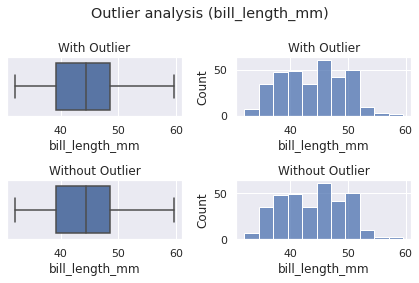

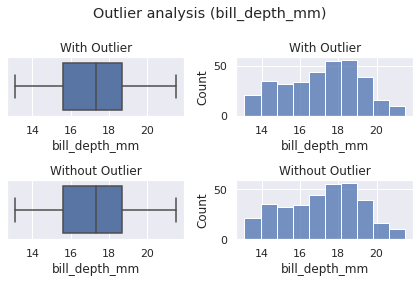

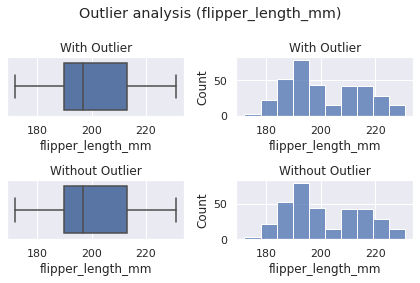

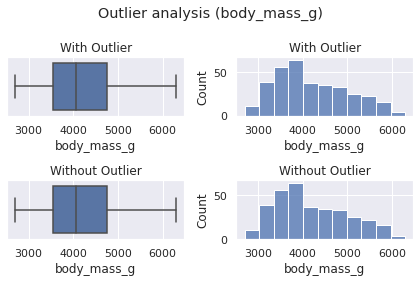

In [4]:
df = sns.load_dataset('penguins')

plot_outliers(df)